# 07. 生成モデル

本章では生成モデルの代表例であるオートエンコーダーを実装します。

datasetはMNISTで、0～9の手書き数字の画像がラベルと一緒に格納されている。これを学習用と検証用に分けて利用します。

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install tensorflow==2.8.0
else:
    print("Not Google Colab")

Not Google Colab


## ライブラリのインポート

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential
from keras import metrics  
from keras.layers import Input, Dense, Lambda, Activation
from keras import backend as K  
import matplotlib.pyplot as plt
random_state = 42

## データセットの用意

データセットはtensorflowに含まれているため、簡単に呼び出すことができます。



In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# 各ピクセルの値を0-1の範囲に収める
train_images = train_images / 255
test_images = test_images / 255

epochs = 10  
batch_size = 128

データを確認して順番に5つ表示してみましょう。

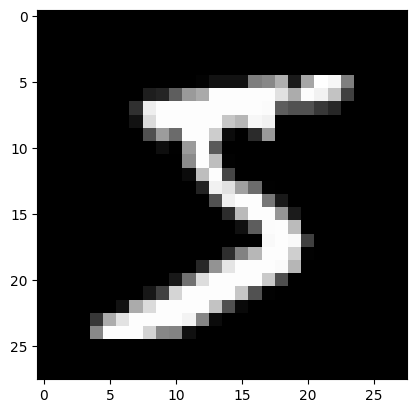

label:  5


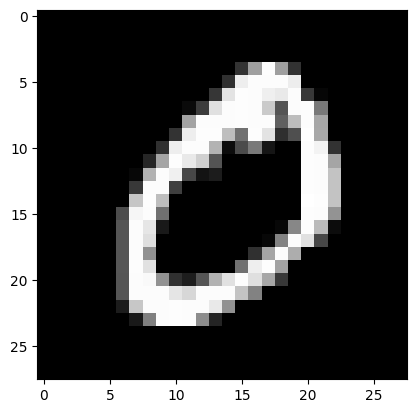

label:  0


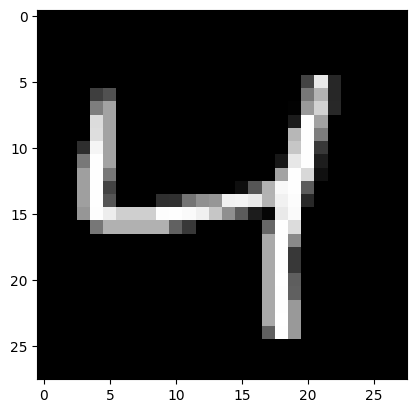

label:  4


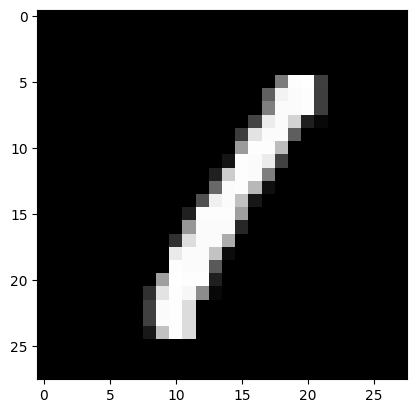

label:  1


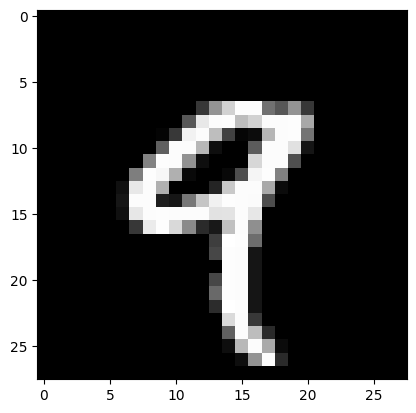

label:  9


In [4]:
# データの確認
# データを5つ表示
for i in range(5):
    plt.gray()
    plt.imshow(train_images[i])
    plt.show()
    print("label: ", train_labels[i])

In [5]:
#一次元に変換する
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [10]:
#work
import tensorflow as tf
a = tf.random.uniform([1, 5])
a.numpy()

array([[0.02451491, 0.97727346, 0.38891768, 0.08309734, 0.09360611]],
      dtype=float32)

In [11]:
fc = tf.keras.layers.Dense(2, activation='relu')

In [12]:
output = fc(a)
output.numpy()

array([[0.        , 0.08905212]], dtype=float32)

# AEによるMNISTの画像生成（TensorFlow） (<u>ライブラリを使用しない</u>)

オートエンコーダーは、エンコーダーで元の画像を低次元の特徴量に圧縮して、デコーダーで低次元の特徴量から元の画像を復元させるようなネットワークです。



**太字**#### AE(Auto Encoder)について

AEとはエンコーダーとデコーダーの2つのニューラルネットワークを結合したモデルで、データの圧縮や異常検知に使われます。

#### AEの基本的な構造

Encoder-Decoderモデルでは、<font color="Green">Encoder</font>により潜在変数に落とし込み（情報を圧縮し）、<font color="Blue">Decoder</font>により潜在変数からデータ生成を行います。

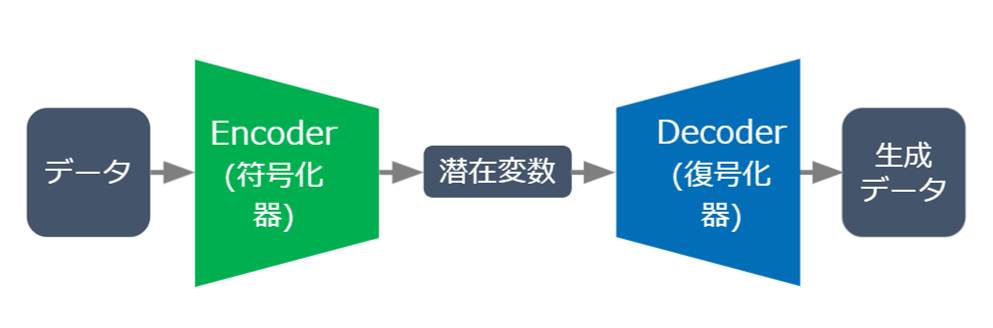

今回実装するモデルの構造は
```
Encoder: 512次元→64次元→32次元→10次元
Decoder: 10次元→32次元→64次元→512次元
```
とします。また、Tensorflowの実装方式はSequential APIまたはFunctional APIとします。



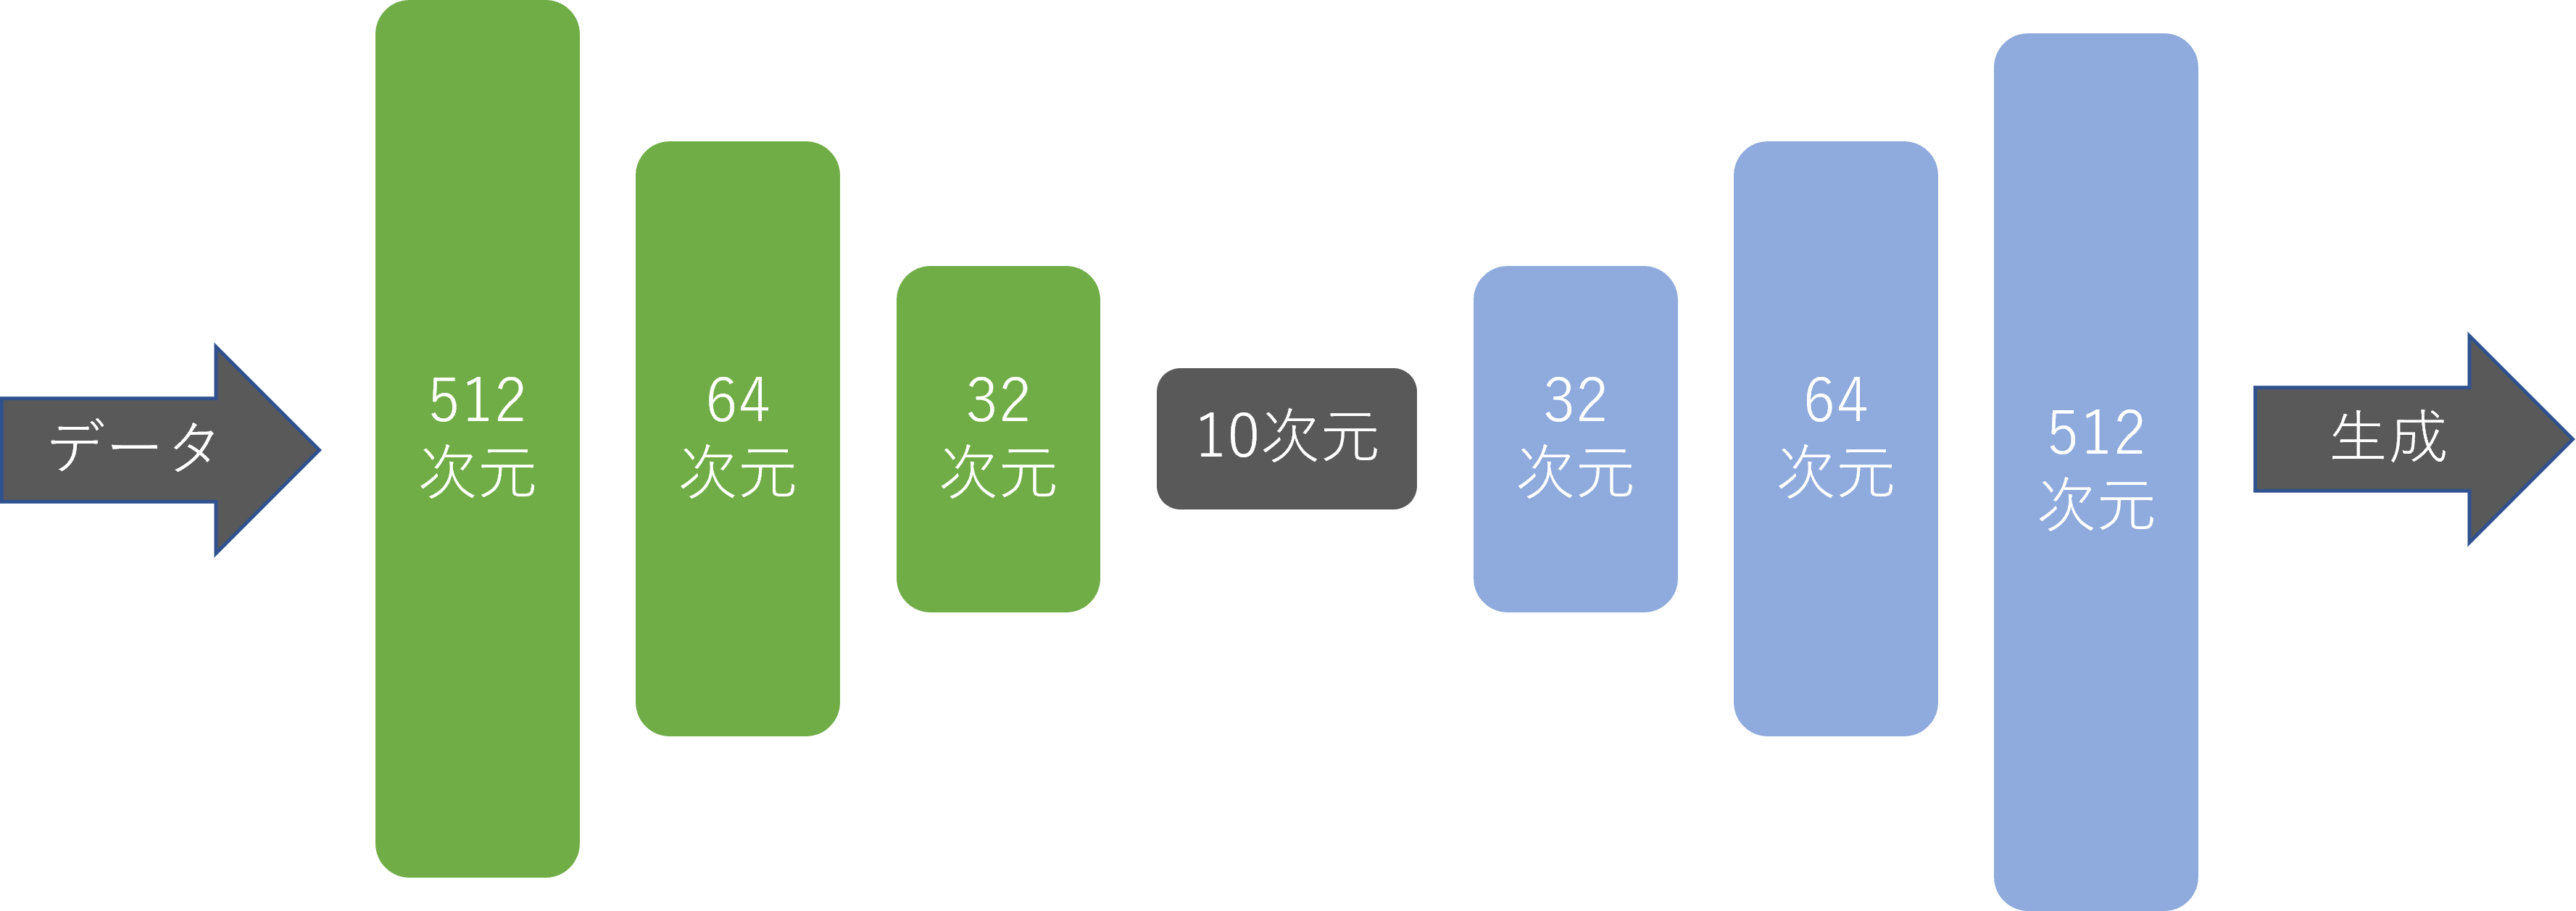

* <font color="Red">問1-1. 第1層ではデータを512次元に圧縮する。データセットの次元を求めて、引数```input_dim```に入力しよう。</font><br>
* <font color="Red">問1-2. 最終層では512次元のデータを元の次元に復元する。データセットの次元を求めて、引数```output_dim```に入力しよう。</font><br>
* <font color="Red">問1-3. エンコーダーでは活性化関数ReLUを介してデータxを各層に読み込ませていきます。**encoder〇**(〇は1～4の数字)を引数として、encoderの層別構造を記述しよう。なお、encoderの4層目は活性化関数は不要です。</font><br>        
* <font color="Red">問1-4. 問1-3と同様の手順で、decoderの層別構造を記述しよう。なお、decoderの4層目の出力にはsigmoid関数を使う必要があります。</font><br>

#### AEの損失関数

reconstruction lossは入力画像をどれだけ正確に復元できたかを表す損失関数です。

reconstruction lossには交差エントロピー誤差を適応します。

$$
\text{reconstruction loss} = \frac{1}{N}\sum^{N}_{i=1} \sum^{C}_{c=1}\{{-x_{ic}\log{y_{ic}}-(1-x_{ic})\log(1-y_{ic})}\}
$$

この時、$x_{ic}$は入力データのある要素を表し、$y_{ic}$は復元されたデータのある要素を表します。

また、$C$はあるデータが持つ説明変数の数を表し、$N$はバッチサイズを表します。

```
【関数の説明】
  Dense(output_dim): 全結合層を実装できる関数です。出力データの次元を `output_dim`で指定します。activationで活性化関数を指定することができます。
  add_loss : 層に損失関数を追加する。
  compile : optimizerに最適化関数を指定することができます。
  summary : モデルがどのような層を構成しているかを出力する。
  
```

* <font color="Red">問1-5. 【loss関数】入力 x と出力 y から、損失関数reconstraction lossの値を算出しよう。

## Functional API

In [34]:
# AEのネットワーク構築
input_dim = 784### 問1-1 ###
output_dim = 784### 問1-2 ###
x = tf.keras.Input(shape=(input_dim,))

encoder1 = Dense(512, activation="relu")(x)### 問1-3 ###
encoder2 = Dense(64, activation="relu")(encoder1)### 問1-3 ###
encoder3 = Dense(32, activation="relu")(encoder2)### 問1-3 ###
encoder4 = Dense(10)(encoder3) 

decoder1 = Dense(32, activation="relu")(encoder4)### 問1-4 ###
decoder2 = Dense(64, activation="relu")(decoder1)### 問1-4 ###
decoder3 = Dense(512, activation="relu")(decoder2)### 問1-4 ###
decoder4 = Dense(output_dim, activation="sigmoid")### 問1-4 ###
y = decoder4(decoder3) ### 問1-4 ###

model_ae = Model(x, y)

# reconstruction lossの計算
# ae_loss = tf.keras.losses.binary_crossentropy(x, y)
ae_loss = K.mean(K.sum(-x * K.log(y+1e-10) - (1 - x) * K.log(1 - y+1e-10), axis = -1))### 問1-5 ###
model_ae.add_loss(ae_loss)
model_ae.compile(optimizer="Adam")
model_ae.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_82 (Dense)               (None, 512)          401920      ['input_7[0][0]']                
                                                                                                  
 dense_83 (Dense)               (None, 64)           32832       ['dense_82[0][0]']               
                                                                                                  
 dense_84 (Dense)               (None, 32)           2080        ['dense_83[0][0]']               
                                                                                            

## Sequential API

In [36]:
# AEのネットワーク構築
input_dim = 784### 問1-1 ###
output_dim = 784### 問1-2 ###


model_ae = Sequential()
model_ae.add(Dense(512, input_shape=(input_dim,)))### 問1-3 ###
model_ae.add(Activation('relu'))
model_ae.add(Dense(64))### 問1-3 ###
model_ae.add(Activation('relu'))
model_ae.add(Dense(32))### 問1-3 ###
model_ae.add(Activation('relu'))
model_ae.add(Dense(10))### 問1-3 ###

model_ae.add(Dense(32))### 問1-4 ###
model_ae.add(Activation('relu'))
model_ae.add(Dense(64))### 問1-4 ###
model_ae.add(Activation('relu'))
model_ae.add(Dense(512))### 問1-4 ###
model_ae.add(Activation('relu'))### 問1-4 ###
model_ae.add(Dense(output_dim))### 問1-4 ###
model_ae.add(Activation('sigmoid'))### 問1-4 ###

# reconstruction lossの計算
def ae_loss(x,y):
    return K.mean(K.sum(-x * K.log(y+1e-10) - (1 - x) * K.log(1 - y+1e-10), axis = -1))### 問1-5 ###

model_ae.compile(optimizer="Adam",loss=ae_loss)
model_ae.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 512)               401920    
                                                                 
 activation_35 (Activation)  (None, 512)               0         
                                                                 
 dense_91 (Dense)            (None, 64)                32832     
                                                                 
 activation_36 (Activation)  (None, 64)                0         
                                                                 
 dense_92 (Dense)            (None, 32)                2080      
                                                                 
 activation_37 (Activation)  (None, 32)                0         
                                                                 
 dense_93 (Dense)            (None, 10)               

## 学習と評価

学習を進めていくと、次第にtest用データに対する損失がreconstraction_lossに近づいていく様子が分かります。

In [37]:
history = model_ae.fit(
    train_images,train_images,
    epochs=10,
    batch_size = batch_size,
    shuffle=True,
    validation_data=(test_images, test_images)
)

Epoch 1/10
600/600 [==============================] - 5s 8ms/step - loss: 147.2150 - val_loss: 108.9991
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 103.2770 - val_loss: 98.2159
Epoch 3/10
600/600 [==============================] - 5s 8ms/step - loss: 96.0850 - val_loss: 92.9013
Epoch 4/10
600/600 [==============================] - 5s 8ms/step - loss: 92.0435 - val_loss: 89.5560
Epoch 5/10
600/600 [==============================] - 5s 8ms/step - loss: 89.0104 - val_loss: 87.2396
Epoch 6/10
600/600 [==============================] - 5s 8ms/step - loss: 86.9930 - val_loss: 85.7133
Epoch 7/10
600/600 [==============================] - 5s 8ms/step - loss: 85.4383 - val_loss: 84.6394
Epoch 8/10
600/600 [==============================] - 5s 8ms/step - loss: 84.3110 - val_loss: 83.8197
Epoch 9/10
600/600 [==============================] - 5s 8ms/step - loss: 83.4167 - val_loss: 83.0683
Epoch 10/10
600/600 [==============================] - 5s 8ms/step - loss: 82.6

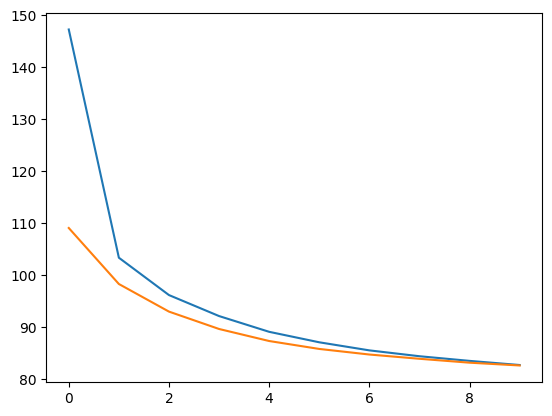

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

### 元画像と復元画像の比較

テスト用データの画像を入力として、AEで再構成した画像と比較してみよう。

まずはオリジナルのテスト用データの画像を表示する。

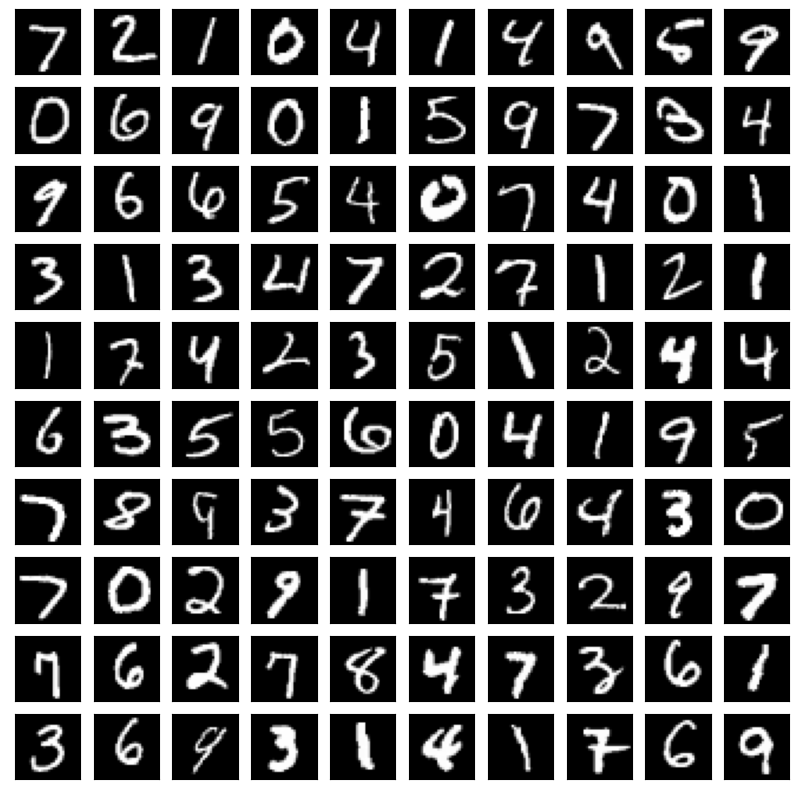

In [29]:
# オリジナルのMNISTイメージ
fig = plt.figure(figsize=(10, 10))
for i in range(100):

    x = test_images[i].reshape(28,28)
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(x, 'gray')

次に、AEで再構成した画像を表示する。

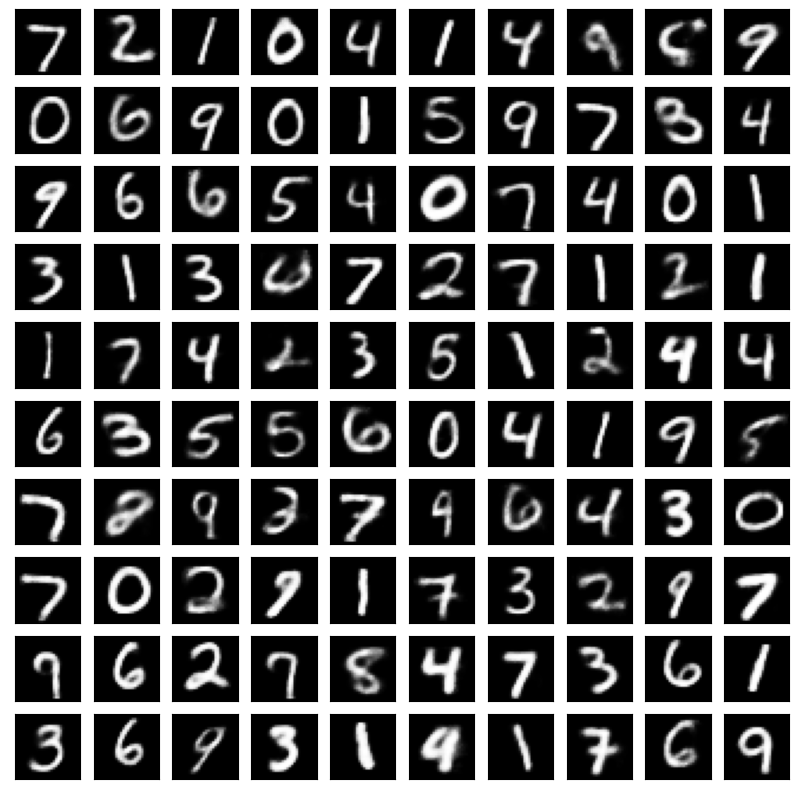

In [30]:
# AEで再構成したMNISTイメージ
fig = plt.figure(figsize=(10, 10))

for i in range(100):
    x= test_images[i]
    x = tf.reshape(x,(-1,28*28)) # 一次元データに変換
    y = model_ae(x)
    im = tf.reshape(y,(28,28)) # 二次元データに変換
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

# VAEによるMNISTの画像生成（TensorFlow） (<u>ライブラリを使用しない</u>)
#### VAEとは

エンコーダの目的はデータ分布を生成することです。

AEはもともと存在するデータを忠実に再現しようとします。しかし、忠実に再現しようとした結果、「遊び」がなく、連続性の高いデータ分布を生成することが出来ません。

そこでVAE(Variational Autoencoder)では、入力データを圧縮して得られる潜在変数を確率変数として表します。さらに潜在変数をガウス分布からサンプリングする制約を設けることでデータの潜在空間上での分布に連続性を持たせることが出来ます。

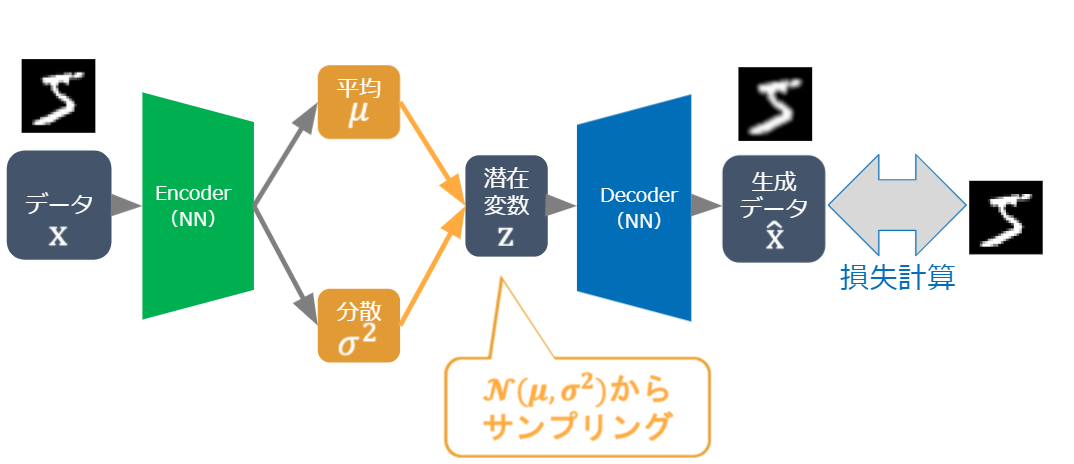

#### VAEのアルゴリズム



1. <font color='Green'>Encoder</font>により、データ$x$から潜在変数$z$の分布の平均$\mu$と分散$\sigma^2$を出力します。<br>
2. 出力された平均$\mu$と分散$\sigma^2$のガウス分布に従う潜在変数$z$をサンプリングします。<br>
3. <font color='Blue'>Decoder</font>により、潜在変数$z$から新たなデータ$\hat{x}$を生成します。<br>
4. 以下の損失関数により損失計算

$$
\text{reconstruction loss} = \frac{1}{N}\sum^{N}_{i=1} \sum^{C}_{c=1}\{{-x_{ic}\log{y_{ic}}-(1-x_{ic})\log(1-y_{ic})}\}
$$

$$
\text{KL} =  - \frac{1}{2N}\sum^{N}_{i=1} \sum^{D}_{d=1}{(1+\log\sigma^2_{id}-\mu^2_{id}-\sigma^2_{id})}
$$
$$
\rm{loss} = \rm{reconstruction~loss} + \rm{KL}
$$

この時、$C$はあるデータが持つ説明変数の数を表し、$N$はバッチサイズを表します。\
また、$D$は平均ベクトルの次元を表します。



#### 実装上の工夫
VAEのアルゴリズムの手順1で潜在変数$z$の分布の平均と分散を算出する際、平均と分散はNNから出力されるので正負どちらの値も取りうる。<br>
しかし、分散が負の値だとガウス分布の算出や損失計算ができないため、分散を正の値にするためにsoftplus関数を適用する。<br>
softplus関数は以下の式で表される。
$$
f(x) = \log (1+e^x)
$$
softplus関数を適用することにより、NNから出力された分散が負の場合であっても正の値に変換される。

## Functional API

* <font color="Red">問2-1. 【encoder関数】平均の算出式を記述してください。活性化関数は線形関数（linear）を使用しましょう。</font><br>
* <font color="Red">問2-2. 【encoder関数】分散の算出式を記述してください。活性化関数はsoftplusを使用しましょう。</font><br>
* <font color="Red">問2-3. 【sampling関数】ガウス分布を算出する関数を完成させてください。</font><br>
【ヒント】
ガウス分布からランダムに抽出された値を$\epsilon$とすると、ガウス分布に従う潜在変数$z$は以下のように算出されます。
$$
\epsilon = \frac{z-\mu}{\sigma}~~~~~\Longrightarrow~~~~~z=\mu+\sigma\epsilon
$$


#### VAEの損失関数

KLダイバージェンスを使った損失は以下のように算出されます。

$$
\text{KL} =  - \frac{1}{2N}\sum^{N}_{i=1} \sum^{D}_{d=1}{(1+\log\sigma^2_{id}-\mu^2_{id}-\sigma^2_{id})}
$$

* <font color="Red">問2-4. 【loss関数】KL_lossの算出式を記述してください。</font><br>

In [31]:
epochs = 15 
batch_size = 100
n_in_out = 784  # 入出力層のニューロン数
n_z = 2  # 潜在変数の数（次元数）
n_mid = 200  # 中間層のニューロン数

In [ ]:
import tensorflow as tf

epsilon = tf.keras.backend.random_normal()

In [40]:
# VAEのネットワーク構築
x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)
h_encoder = Dense(n_mid, activation="relu")(h_encoder)

mean = Dense(n_z, name='mean')(h_encoder)### 問2-1 ###
var = K.softplus(Dense(n_z, name="variance")(h_encoder))### 問2-2 ###

# 潜在変数をサンプリングするための関数
def z_sample(args):
    mean, var = args  # 潜在変数の平均値と、分散
    epsilon = K.random_normal(shape=K.shape(var), mean=0, stddev=1) #平均0,標準偏差1の乱数を発生
    return mean + epsilon*tf.math.sqrt(var)### 問2-3 ###
    
z = Lambda(z_sample, output_shape=(n_z,))([mean, var])

mid_decoder1 = Dense(n_mid, activation="relu")
h_decoder = mid_decoder1(z)
mid_decoder2= Dense(n_mid, activation="relu")
h_decoder = mid_decoder2(h_decoder)
out_decoder = Dense(n_in_out, activation="sigmoid")
y = out_decoder(h_decoder)

# VAEのモデルを生成
model_vae_fun = Model(x, y)

# 損失関数
rec_loss = K.mean(K.sum(-x * K.log(y+1e-10) - (1 - x) * K.log(1 - y+1e-10), axis = -1))
kl_loss = -0.5 * K.mean(K.sum(1 + K.log(var) - mean**2 - var, axis=-1))### 問2-4 ###
vae_loss = rec_loss + kl_loss

model_vae_fun.add_loss(vae_loss)
model_vae_fun.compile(optimizer="Adam")
model_vae_fun.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_98 (Dense)               (None, 200)          157000      ['input_8[0][0]']                
                                                                                                  
 dense_99 (Dense)               (None, 200)          40200       ['dense_98[0][0]']               
                                                                                                  
 variance (Dense)               (None, 2)            402         ['dense_99[0][0]']               
                                                                                            

 add_loss_6 (AddLoss)           ()                   0           ['tf.__operators__.add_7[0][0]'] 
                                                                                                  
Total params: 396,388
Trainable params: 396,388
Non-trainable params: 0
__________________________________________________________________________________________________


## Sequential API

* <font color="Red">問2-1. 【encoder関数】平均の算出式を記述してください。活性化関数は線形関数（linear）を使用しましょう。</font><br>
* <font color="Red">問2-2. 【encoder関数】分散の算出式を記述してください。活性化関数はsoftplusを使用しましょう。</font><br>
* <font color="Red">問2-3. 【sampling関数】ガウス分布を算出する関数を完成させてください。</font><br>
【ヒント】
ガウス分布からランダムに抽出された値を$\epsilon$とすると、ガウス分布に従う潜在変数$z$は以下のように算出されます。
$$
\epsilon = \frac{z-\mu}{\sigma}~~~~~\Longrightarrow~~~~~z=\mu+\sigma\epsilon
$$


#### VAEの損失関数

KLダイバージェンスを使った損失は以下のように算出されます。

$$
\text{KL} =  - \frac{1}{2N}\sum^{N}_{i=1} \sum^{D}_{d=1}{(1+\log\sigma^2_{id}-\mu^2_{id}-\sigma^2_{id})}
$$

* <font color="Red">問2-4. 【loss関数】KL_lossの算出式を記述してください。</font><br>

In [41]:
epochs = 15 
batch_size = 100
n_in_out = 784  # 入出力層のニューロン数
n_z = 2  # 潜在変数の数（次元数）
n_mid = 200  # 中間層のニューロン数

In [64]:
class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.h_encoder = tf.keras.Sequential([
            Dense(n_mid, name = 'h_encoder1', activation='relu'),
            Dense(n_mid, name = 'h_encoder2', activation='relu'),
        ])
        self.mean_encoder = Dense(latent_dim, name = 'mid_mean_encoder')
        self.var_encoder = Dense(latent_dim, name = 'mid_var_encoder')
        self.decoder = tf.keras.Sequential(
            [
                Dense(n_mid, name = 'mid_decoder', activation="relu"),
                Dense(n_mid, name = 'h_decoder1', activation="relu"),
                Dense(n_in_out, name = 'h_decoder2', activation="sigmoid") 
            ]
        )

    def encode(self, x):
        x = self.h_encoder(x)
        mean =  self.mean_encoder(x)### 問2-1 ###
        var =  K.softplus(self.var_encoder(x))### 問2-2 ###
        return mean, var
    
        # 潜在変数をサンプリングするための関数
    def z_sample(self, mean, var):
        epsilon = K.random_normal(shape=K.shape(var), mean=0, stddev=1) #平均0,標準偏差1の乱数を発生
        return mean + epsilon*tf.math.sqrt(var) ### 問2-3 ###

    def decode(self, z):
        x = self.decoder(z)
        return x

In [65]:
optimizer = tf.keras.optimizers.Adam(1e-3)

def vae_loss(model, x):
    mean, var = model.encode(x)
    z = model.z_sample(mean, var)
    y = model.decode(z)
    rec_loss = n_in_out * K.mean(K.sum(-x * K.log(y+1e-10) - (1 - x) * K.log(1 - y+1e-10), axis = -1))
    kl_loss = -0.5 * K.mean(K.sum(1 + K.log(var) - mean**2 - var, axis=-1))### 問2-4 ###
    vae_loss = rec_loss + kl_loss

    return vae_loss


def train_step(model, inputs, optimizer):
    with tf.GradientTape() as tape:
        loss = vae_loss(model, inputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

model_vae_seq = VAE(n_z)

In [66]:
# 訓練ループを回すためのデータセットを作成
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(60000).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(10000).batch(batch_size))

## 学習と評価(Functional API)

In [57]:
history = model_vae_fun.fit(train_images,
                            shuffle=True,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(test_images, None))

Epoch 1/15
600/600 [==============================] - 3s 5ms/step - loss: 145.2239 - val_loss: 145.8055
Epoch 2/15
600/600 [==============================] - 3s 4ms/step - loss: 144.5879 - val_loss: 145.6370
Epoch 3/15
600/600 [==============================] - 3s 4ms/step - loss: 144.2737 - val_loss: 145.5537
Epoch 4/15
600/600 [==============================] - 3s 4ms/step - loss: 144.0382 - val_loss: 145.5651
Epoch 5/15
600/600 [==============================] - 3s 4ms/step - loss: 143.7306 - val_loss: 144.3371
Epoch 6/15
600/600 [==============================] - 3s 4ms/step - loss: 143.5197 - val_loss: 144.3377
Epoch 7/15
600/600 [==============================] - 3s 4ms/step - loss: 143.1977 - val_loss: 144.5914
Epoch 8/15
600/600 [==============================] - 3s 4ms/step - loss: 142.8718 - val_loss: 144.1074
Epoch 9/15
600/600 [==============================] - 3s 4ms/step - loss: 142.5678 - val_loss: 143.6486
Epoch 10/15
600/600 [==============================] - 3s 4ms/st

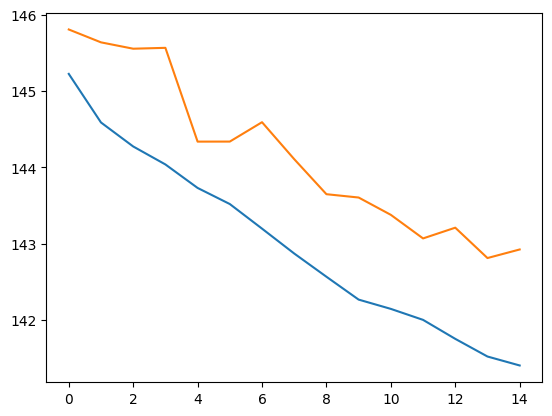

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## 学習と評価(Sequential API)

In [67]:
for epoch in range(1, epochs + 1):
  
    for train_x in train_dataset:
        train_x = tf.cast(train_x, tf.float32)
        train_step(model_vae_seq, train_x, optimizer)

    loss = metrics.Mean()
    for test_x in test_dataset:
        test_x = tf.cast(test_x, tf.float32)
        loss(vae_loss(model_vae_seq, test_x))
    elbo = loss.result()
    
    print('Epoch: {}, loss: {}'.format(epoch,elbo))

Epoch: 1, loss: 125786.3125
Epoch: 2, loss: 118849.03125
Epoch: 3, loss: 115199.5078125
Epoch: 4, loss: 113213.7578125
Epoch: 5, loss: 111675.390625
Epoch: 6, loss: 110816.6015625
Epoch: 7, loss: 109773.2265625
Epoch: 8, loss: 109278.0234375
Epoch: 9, loss: 108529.8203125
Epoch: 10, loss: 108442.1796875
Epoch: 11, loss: 107621.5234375
Epoch: 12, loss: 106927.0390625
Epoch: 13, loss: 106691.6796875
Epoch: 14, loss: 105987.421875
Epoch: 15, loss: 105593.5625


## 元画像と復元画像の比較(Functinal API)

テスト用データの画像を入力として、VAEで再構成した画像と比較してみましょう。

まずはオリジナルのテスト用データの画像を表示します。

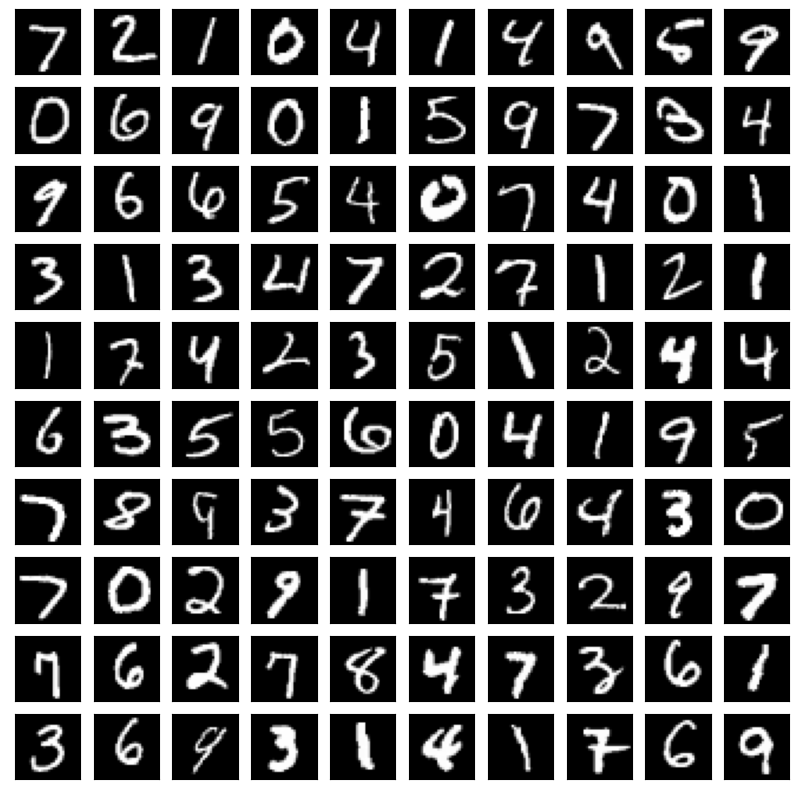

In [48]:
# オリジナルのMNISTイメージ
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    x = test_images[i].reshape(28,28)
    im = x
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

次に、VAEで再構成した画像を表示します。

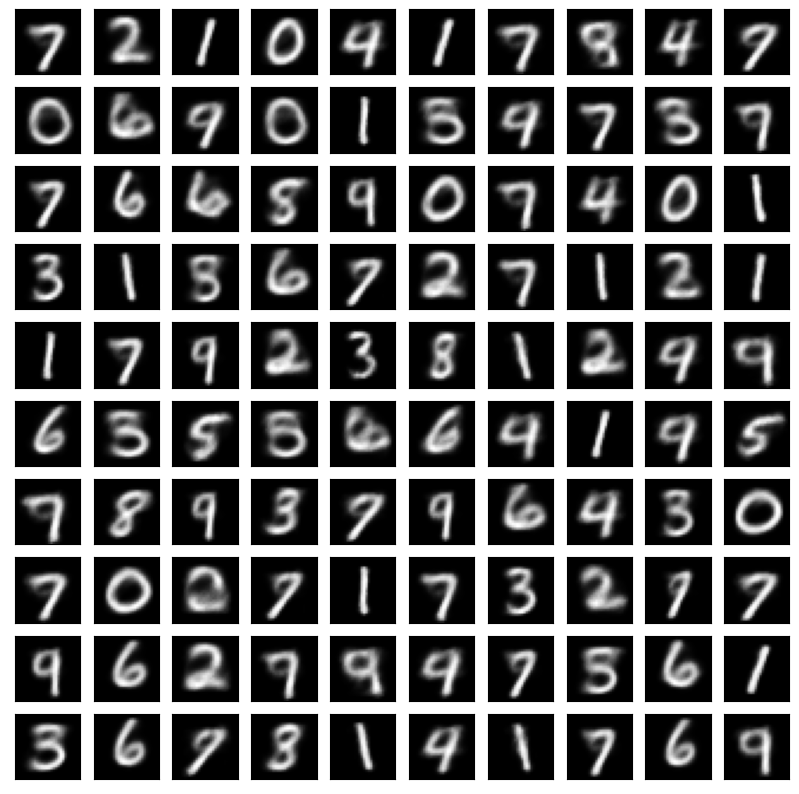

In [49]:
# VAEで再構成したMNISTイメージ
fig = plt.figure(figsize=(10, 10))

for i in range(100):
    x = test_images[i]
    x = tf.reshape(x,(-1,28*28))
    y = model_vae_fun(x)
    im = tf.reshape(y,(28,28))
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

潜在変数からランダムサンプリングしてイメージを生成すると、以下のようになります。

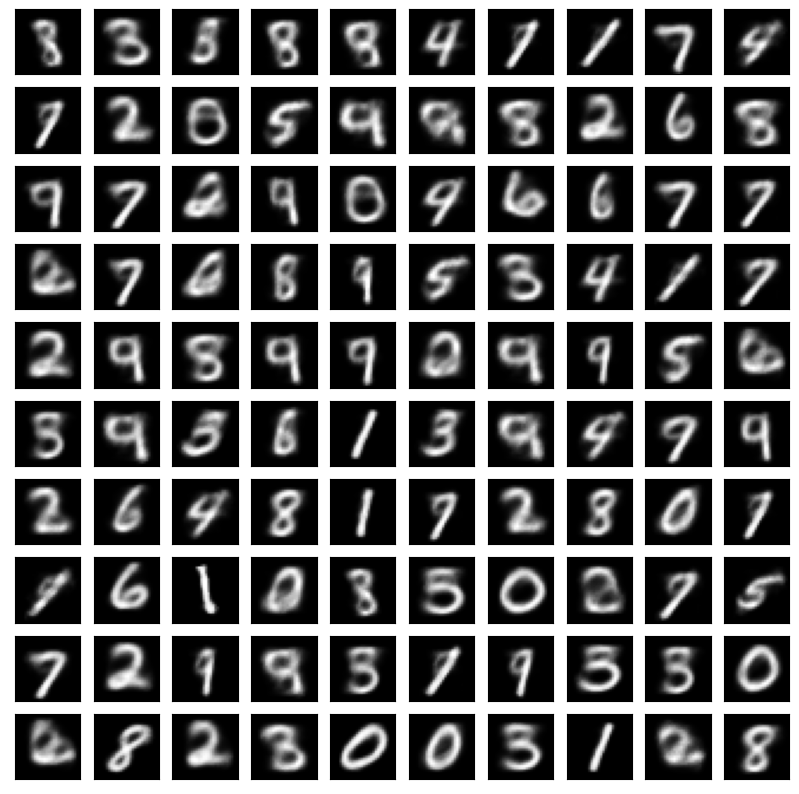

In [50]:
# 潜在変数からランダムサンプリング(潜在変数をランダムに決め, その潜在変数から生成されるMNISTイメージ)
fig = plt.figure(figsize=(10, 10))
input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder1(input_decoder)
h_decoder = mid_decoder2(h_decoder)
y = out_decoder(h_decoder)

for i in range(100):
    z = tf.random.normal([1, n_z])
    h_decoder = mid_decoder1(z)
    h_decoder = mid_decoder2(h_decoder)
    y = out_decoder(h_decoder)
    im = tf.reshape(y,(28,28))
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

最後に、潜在変数による連続的な変化を可視化してみましょう。

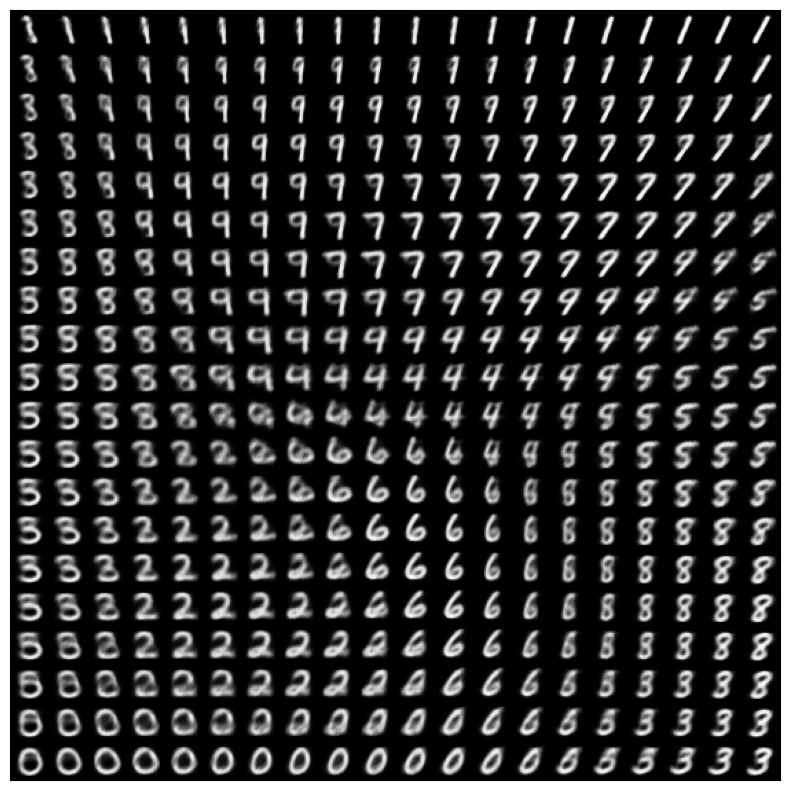

In [51]:
from scipy.stats import norm
# 画像の生成器
input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder1(input_decoder)
h_decoder = mid_decoder2(h_decoder)
y = out_decoder(h_decoder)
generator = Model(input_decoder, y)

# 画像を並べる設定
n = 20  # 手書き文字画像を16x16並べる
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))  # 全体の画像

# 潜在変数
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

#  潜在変数を変化させて画像を生成
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        decoded = generator.predict(np.array([[xi, yi]]))  # x軸、y軸の順に入れる
        digit = decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size : (i+1)*digit_size, j*digit_size: (j+1)*digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 軸目盛りのラベルと線を消す
plt.show()

## 元画像と復元画像の比較(Sequential API)

テスト用データの画像を入力として、VAEで再構成した画像と比較してみましょう。

まずはオリジナルのテスト用データの画像を表示します。

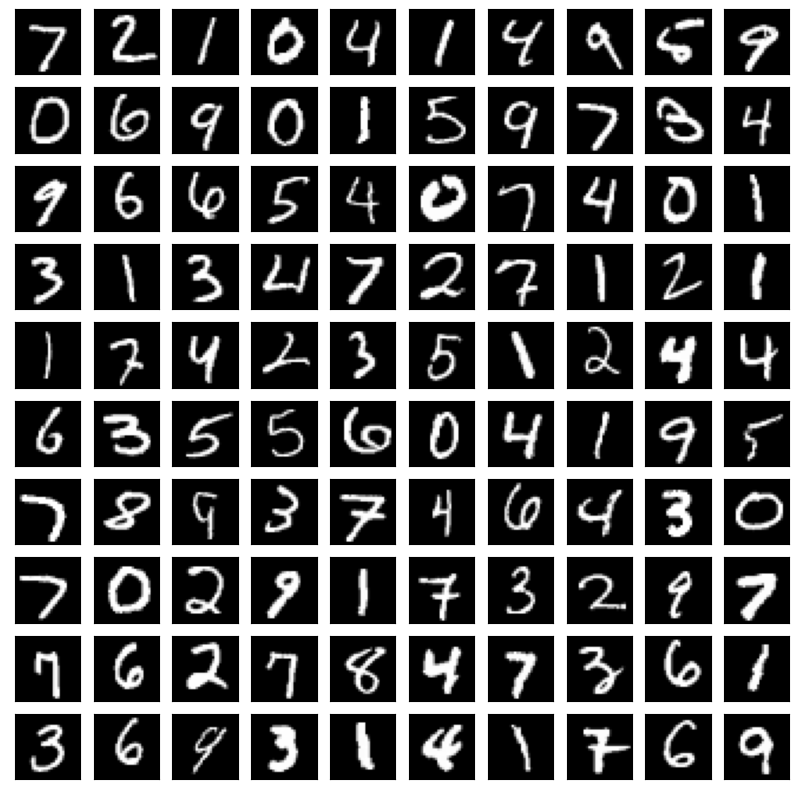

In [68]:
# オリジナルのMNISTイメージ
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    x = test_images[i].reshape(28,28)
    im = x
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

次に、VAEで再構成した画像を表示します。

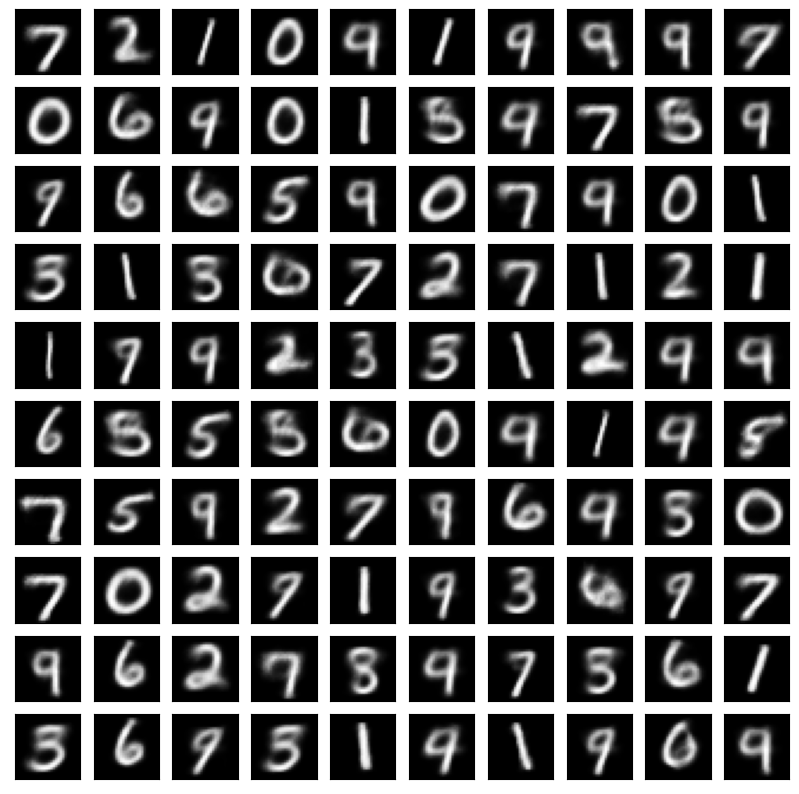

In [69]:
# VAEで再構成したMNISTイメージ
fig = plt.figure(figsize=(10, 10))

for i in range(100):
    x = test_images[i]
    x = tf.reshape(x,(-1,28*28))
    mean, var = model_vae_seq.encode(x)
    z = model_vae_seq.z_sample(mean, var)
    y = model_vae_seq.decode(z)
    im = tf.reshape(y,(28,28))
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

潜在変数からランダムサンプリングしてイメージを生成すると、以下のようになります。

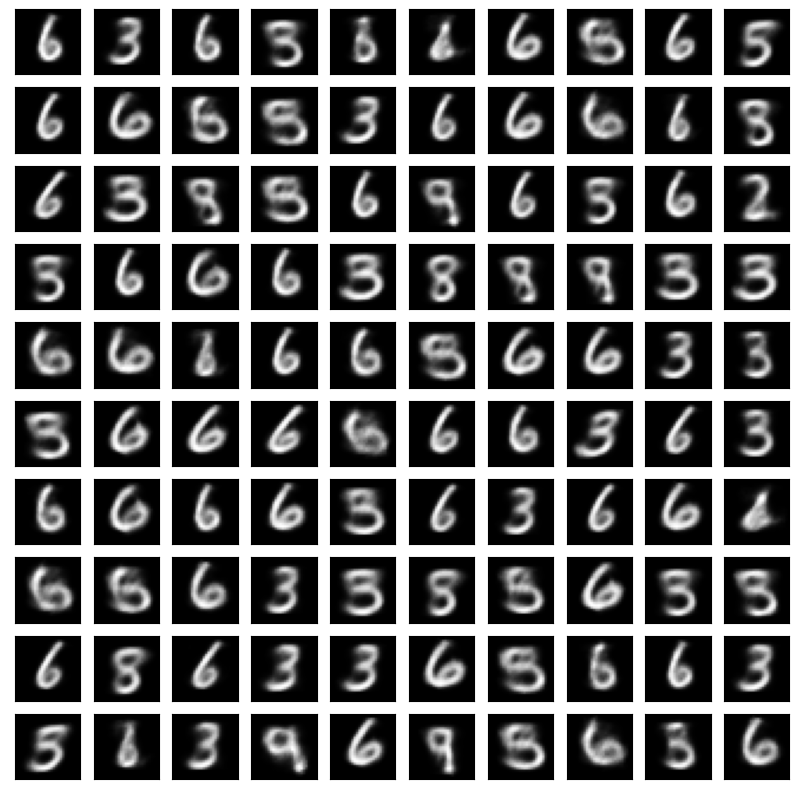

In [70]:
fig = plt.figure(figsize=(10, 10))

for i in range(100):
    z = tf.random.normal([1, n_z])
    y = model_vae_seq.decode(z)
    im = tf.reshape(y,(28,28))
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

最後に、潜在変数による連続的な変化を可視化してみましょう。

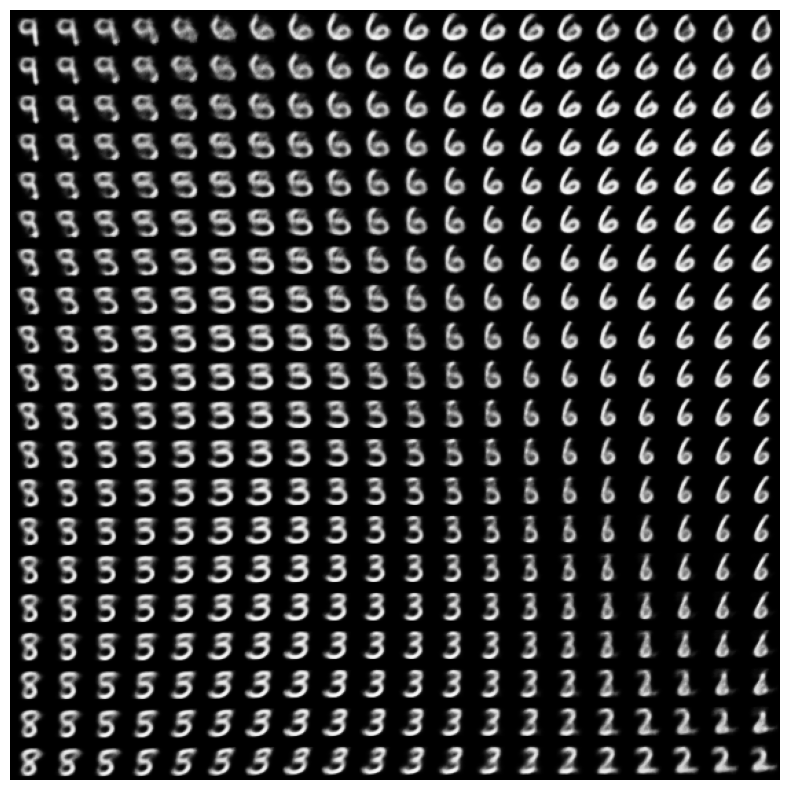

In [71]:
n  = 20
digit_size = 28
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

image_width = digit_size*n
image_height = image_width
image = np.zeros((image_height, image_width))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      x_decoded = model_vae_seq.decode(np.array([[xi, yi]]))
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='Greys_r')
plt.axis('Off')
plt.show()